# Data and model testing

In [1]:
import os

# gets rid of irritating warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Data preprocessing and initial quality checking

We will be using [booking.com reviews dataset](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download), with over 500 thousand reviews of hotels. They are either positive or negative, and we will focus on review sentiment. We have [hosted it on HuggingFace](https://huggingface.co/datasets/morgul10/booking_reviews), with just the relevant columns.

We will start with loading the data and initial checks - a **smoke test** of the data. Aim is to understand our dataset, and to detect obvious and serious problems. It is always a necessary process in ML.

Most basic checks, which should always be performed, are:
- data length
- column types
- example rows
- exact duplicates check
- labels distributions (for supervised problems)
- more specific checks depending on the modality, e.g. text lengths distribution in NLP

In [2]:
import pandas as pd

from datasets import load_dataset


df_raw = load_dataset("morgul10/booking_reviews")["train"].to_pandas()
df_neg = df_raw["Negative_Review"].str.strip()
df_pos = df_raw["Positive_Review"].str.strip()

In [3]:
print("Total data length:", len(df_raw))
print("Negative reviews:", len(df_neg))
print("Positive reviews:", len(df_pos))

Total data length: 515738
Negative reviews: 515738
Positive reviews: 515738


In [4]:
print("Data types:")
display(df_raw.dtypes)

Data types:


Negative_Review    object
Positive_Review    object
dtype: object

In [5]:
print("First rows:")
display(df_raw.head(10))

First rows:


,Negative_Review,Positive_Review
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...
1,No Negative,No real complaints the hotel was great great ...
2,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,You When I booked with your company on line y...,Amazing location and building Romantic setting
5,Backyard of the hotel is total mess shouldn t...,Good restaurant with modern design great chil...
6,Cleaner did not change our sheet and duvet ev...,The room is spacious and bright The hotel is ...
7,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...
8,Even though the pictures show very clean room...,No Positive
9,The aircondition makes so much noise and its ...,The room was big enough and the bed is good T...


In [6]:
print("Last rows:")
display(df_raw.tail(10))

Last rows:


,Negative_Review,Positive_Review
515728,Everything,Nothing
515729,No Negative,The breakfast was excelent lots of fress frui...
515730,no free parking the room was in another build...,large room
515731,No parking Public parking garage is 15 Euro p...,Good breakfast
515732,No Negative,helpful staff allowed me to check in early as...
515733,no trolly or staff to help you take the lugga...,location
515734,The hotel looks like 3 but surely not 4,Breakfast was ok and we got earlier check in
515735,The ac was useless It was a hot week in vienn...,No Positive
515736,No Negative,The rooms are enormous and really comfortable...
515737,I was in 3rd floor It didn t work Free Wife,staff was very kind


<Axes: title={'center': 'Negative reviews lengths'}, ylabel='Frequency'>

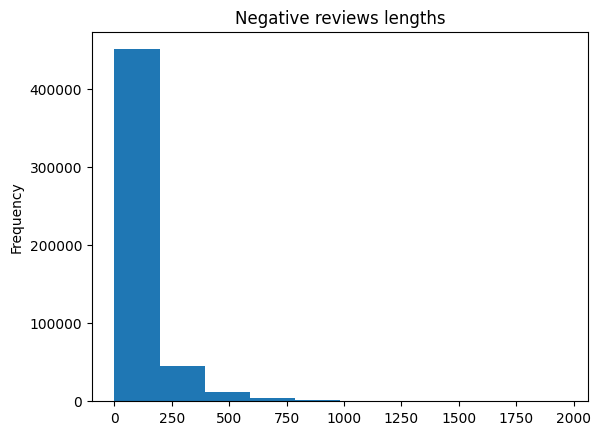

In [7]:
df_neg.str.len().plot.hist(title="Negative reviews lengths")

<Axes: title={'center': 'Positive reviews lengths'}, ylabel='Frequency'>

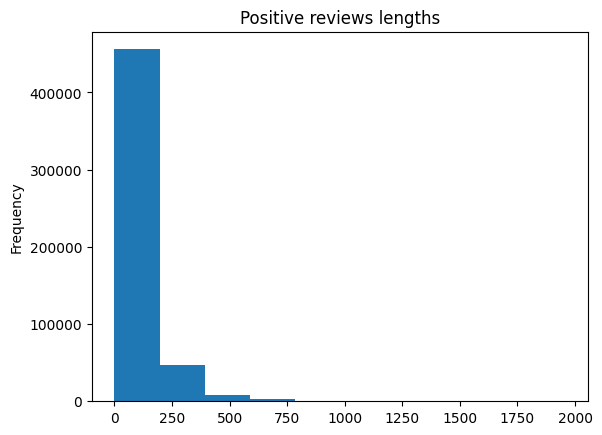

In [8]:
df_pos.str.len().plot.hist(title="Positive reviews lengths")

As you can see, the data contains quite a few "No Negatives" and "No Positive" rows. This is a widespread problem with "empty" rows, which are not really empty. They can take a form of:
- default text, like we have here (frequent in automated forms, data from web scraping etc.)
- empty string instead of NULL
- deleted rows, but only marked with "deleted" column (frequent in data warehouses)

Those problems can also crop up during inference (e.g., empty text), and should be handled properly.

This is a particular instance of **duplicate data** problem, which is surprisingly common. Another reason may be that people writing texts don't care, e.g. input generic answers like "ok" or "everything". This biases the model, essentially putting more weights on those texts. Worse, they can have different labels, which introduces strong noise.

Let's see how frequent is this problem.

### Exercise 1 (1 point)

Check the percentage of 20 most common text duplicates. This can be achieved with Pandas code conceptually similar to a combination of GROUP BY and COUNT aggregation. Check it:
- in positive and negative subsets
- for the whole dataset

In [9]:
# positive subset
top20_pos = df_pos.value_counts().head(20)
print("Top 20 duplicate positive reviews:")
display(top20_pos)
summed_percentage_pos = top20_pos.sum() / len(df_pos) * 100
print("Summed percentage in positive subset:", summed_percentage_pos)

# or for percantages of each entry:
# print("Percentage share:")
# display((top20_pos / len(df_pos)) * 100)

Top 20 duplicate positive reviews:


Positive_Review
No Positive               35946
Location                  10137
Everything                 2897
location                   1736
Nothing                    1468
Great location             1419
The location               1341
Good location              1203
Breakfast                   664
Friendly staff              603
Excellent location          547
Staff                       486
Location and staff          371
everything                  371
Location was great          294
Location was good           277
Everything was perfect      276
Comfy bed                   263
Good breakfast              248
Location is great           236
Name: count, dtype: int64

Summed percentage in positive subset: 11.785635341975965


In [10]:
# negative subset
top20_neg = df_neg.value_counts().head(20)
print("Top 20 duplicate negative reviews:")
display(top20_neg)
summed_percentage_neg = top20_neg.sum() / len(df_neg) * 100
print("Summed percentage in negative subset:", summed_percentage_neg)

# print("Percentage share:")
# display((top20_neg / len(df_neg)) * 100)

Top 20 duplicate negative reviews:


Negative_Review
No Negative               127890
Nothing                    18531
nothing                     2508
None                        1166
N A                         1060
                             849
Nothing really               570
N a                          520
All good                     470
Small room                   455
No complaints                450
Breakfast                    449
Location                     421
Nothing at all               415
Everything                   367
Nothing to dislike           335
none                         322
Price                        301
Nil                          269
Everything was perfect       247
Name: count, dtype: int64

Summed percentage in negative subset: 30.55718213511512


In [11]:
# # whole dataset
# top20_duplicates = df_raw.value_counts().head(20)
# print("Top 20 duplicate reviews:")
# display(top20_duplicates)
# print("Percentage share:")
# display((top20_duplicates / len(df_raw)) * 100)
df_all = pd.concat([df_neg, df_pos], ignore_index=True)

top20_all = df_all.value_counts().head(20)
print("Top 20 duplicate reviews across the whole dataset:")
display(top20_all)
summed_percentage_all = top20_all.sum() / len(df_all) * 100
print("Summed percentage in the whole dataset:", summed_percentage_all)


# print("Percentage share:")
# display((top20_all / len(df_all)) * 100)

Top 20 duplicate reviews across the whole dataset:


No Negative           127890
No Positive            35946
Nothing                19999
Location               10558
Everything              3264
nothing                 2742
location                1815
Great location          1426
The location            1402
Good location           1213
None                    1198
Breakfast               1113
N A                     1093
                        1032
Staff                    629
Friendly staff           606
Nothing really           604
All good                 583
Excellent location       548
N a                      537
Name: count, dtype: int64

Summed percentage in the whole dataset: 20.766164215163514


### Manual data cleaning

Imagine training (and testing!) a model on data, where about 25% of negative class is duplicated, or has useless values like "none". Not a good idea, so we will remove those duplicates simply by using a case-insensitive regular expression. We will also remove words like "breakfast" or "location," which do not discriminate at all between positive and negative sentiment.

In [12]:
to_remove = [
    "No Negative",
    "No Positive",
    "nothing",
    "nothing really",
    "none",
    "n a",
    "na",
    "everything",
    "location",
    "the location",
    "breakfast",
    "the breakfast",
    "staff",
]
to_remove = [f"^{word}$" for word in to_remove]
to_remove = "|".join(to_remove)
to_remove

'^No Negative$|^No Positive$|^nothing$|^nothing really$|^none$|^n a$|^na$|^everything$|^location$|^the location$|^breakfast$|^the breakfast$|^staff$'

We will also perform two common cleaning steps: deduplication and removing empty strings. We can safely assume that people are lazy and write short, generic reviews, so there will be quite a few duplicates even after removing the most obvious cases.

In [13]:
df_neg_filtered = df_neg[
    ~df_neg.str.contains(to_remove, case=False, na=True, regex=True)
]
df_pos_filtered = df_pos[
    ~df_pos.str.contains(to_remove, case=False, na=True, regex=True)
]

# empty strings removal
df_neg_filtered = df_neg_filtered[df_neg_filtered.str.len() > 0]
df_pos_filtered = df_pos_filtered[df_pos_filtered.str.len() > 0]

df_neg_filtered = df_neg_filtered.reset_index(drop=True)
df_pos_filtered = df_pos_filtered.reset_index(drop=True)

df_neg_filtered = df_neg_filtered.to_frame().rename(columns={"Negative_Review": "text"})
df_pos_filtered = df_pos_filtered.to_frame().rename(columns={"Positive_Review": "text"})

df_neg_filtered["label"] = 0
df_pos_filtered["label"] = 1

print("Negative samples after filtering:", len(df_neg_filtered))
print("Positive samples after filtering:", len(df_pos_filtered))

df_all = pd.concat([df_neg_filtered, df_pos_filtered], ignore_index=True)
df_all = df_all.drop_duplicates(ignore_index=True)

Negative samples after filtering: 359750
Positive samples after filtering: 459388


Lastly, we have quite a lot of data, so we'll randomly subsample it. We will use stratification, so that the label distribution will be the same after sampling.

**Modify this** depending on your hardware. Very good GPU should handle up to ~100k samples, medium-grade GPU about ~10-50k, and CPU about 5k. The more samples you process, the better the results will be.

In [14]:
from sklearn.utils import resample


df = resample(
    df_all, replace=False, n_samples=5000, random_state=0, stratify=df_all["label"]
)
df = df.reset_index(drop=True)
df

,text,label
0,Nice staff and rooms Good breakfast choices go...,1
1,No heating in our room had to ask twice for he...,0
2,always clean and neat,1
3,Excellent friendly staff Very pleasant quiet room,1
4,Brilliant location for london theatres,1
...,...,...
4995,The only complaint i have is i wished that the...,0
4996,Room a little dark due to external sun blinds,0
4997,Great staff Superb breakfast Lovely bed,1
4998,The beds were comfy but for what i am paying i...,0


## CleanLab blackbox testing

[CleanLab library](https://github.com/cleanlab/cleanlab) aims to provide a blackbox, dead simple to use solution to ensure data quality. It can clean both data and labels, and works for any models. It is based on the framework of **confident learning (CL)**, originally created for detecting problems with data annotations.

The main idea is as follows. A reasonably good model trained on the data should be very confident about properly annotated texts, and uncertain about ambiguous or incorrectly annotated texts. This is measured by predicted class probabilities. There are, of course, more details (e.g., class-conditioning, distinguishing model and data errors), but the general idea is really simple, and works with any data modality. It can not only detect errors, but also fix them. If another label is predicted with very high confidence, there is a high chance it's the correct one.

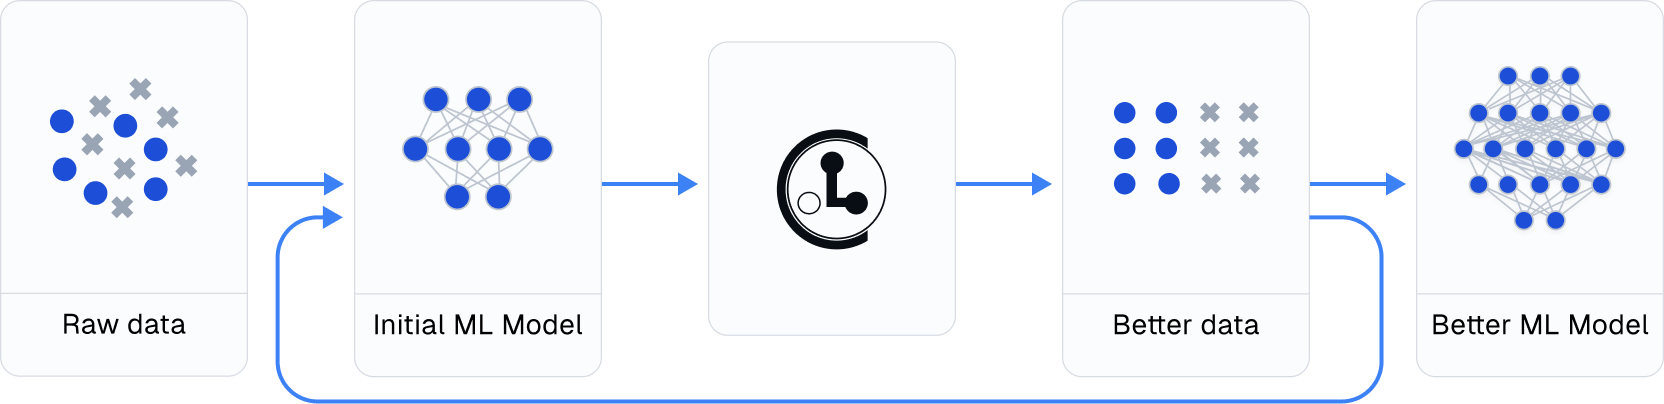

Researchers in confidence learning, and creators of CleanLab, used this methodology in paper ["Pervasive label errors in test sets destabilize machine learning benchmarks" C.G. Northcutt et al](https://arxiv.org/abs/2103.14749). They showed that in popular text and image benchmarking datasets, up to 10% of labels are incorrect.

We will take a similar approach to test our dataset. To avoid a chicken-and-egg problem (we don't have a model yet, but we need model probabilities), we need the **initial model**. A simple, yet effective approach is using a pretrained embedding model, combined with a linear classifier. This method is equivalent to freezing weights and training just the classifier head. Both embeddings and probability predictions are then used by CleanLab to detect problems.

For text classification, the workflow recommended by [HuggingFace Open-Source AI Cookbook](https://huggingface.co/learn/cookbook/en/issues_in_text_dataset) is:
1. Compute text embeddings with a pretrained Sentence Transformer for feature extraction
2. Train logistic regression with cross-validation
3. Gather predicted probabilities (model confidence scores) for validation sets
4. Use CleanLab using this data

Bonus: we originally detected some problems with duplicates in this dataset also by using CleanLab.

### Exercise 2 (1 point)

Implement the `get_initial_model_data()` function:
1. Compute text embeddings with [sentence-transformers](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and `all-MiniLM-L6-v2` model.
2. Create `LogisticRegression` object
3. Train logistic regression and get probability predictions using `cross_val_predict()`. Note that it requires explicitly specifying that `predict_proba()` method should be used, in order to return probabilities, rather than 0/1 labels.


In [15]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def get_initial_model_data(
    texts: np.ndarray, labels: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts, show_progress_bar=True)

    clf = LogisticRegression(
        max_iter=1000,  # max_iter bcs high-dim embeddings can require more iter to converge
        n_jobs=-1,  # n_jobs to use all cores
    )

    # stratified cv ensures each fold has the same class distr as the dataset;
    # this leads to more reliable (better calibrated) prob estimates for CleanLab
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    pred_probs = cross_val_predict(
        clf, embeddings, labels, cv=cv, method="predict_proba"
    )

    return embeddings, pred_probs

#### Verification

In [16]:
texts = df["text"].values
labels = df["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

And now, we can use the CleanLab with the obtained embeddings and probability predictions.

In [17]:
from cleanlab import Datalab


data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 152 issues found in the dataset.
Dataset Information: num_examples: 5000, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label         114
       outlier          27
near_duplicate          10
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having lab

About 1.9% of duplicates, even after our cleaning, are quite expected. Many people don't really care and write short, generic reviews. Still, the data-driven approach confirms it, and we'll take a closer look at this. Additionally, about 2.2% of mislabeled data looks quite problematic.

To programmatically inspect a given issue, `.get_issues()` method is used. For a given issue type (see report above for exact names), it returns a DataFrame with score for each sample. Lower score means higher risk of problems. It also returns a column with a boolean indicator whether a given sample has the problem, e.g. `is_near_duplicate_issue` or `is_label_issue`, which uses a default threshold for the score.

Let's inspect the duplicate issues for now.

In [18]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

Row index indicates the row with a problem, and `near_duplicate_sets` are indices of duplicate rows. `distance_to_nearest_neighbor` measures distance between embeddings. Let's see the top 10 cases with most obvious duplicates.

In [19]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: Wifi slow in the room
	Duplicates: ['Slow wifi in our room']

Text: Slow wifi in our room
	Duplicates: ['Wifi slow in the room']

Text: Friendly staff excellent location
	Duplicates: ['very friendly staff excellent location']

Text: very friendly staff excellent location
	Duplicates: ['Friendly staff excellent location' 'Staff very friendly Great location']

Text: Excellent location friendly and helpful staff
	Duplicates: ['Good location friendly and helpful staff']

Text: Good location friendly and helpful staff
	Duplicates: ['Excellent location friendly and helpful staff']

Text: Staff very friendly Great location
	Duplicates: ['very friendly staff excellent location'
 'staff are very friendly Great location']

Text: Location excellent Value for money
	Duplicates: ['Location good value for money']

Text: Location good value for money
	Duplicates: ['Location excellent Value for money']

Text: staff are very friendly Great location
	Duplicates: ['Staff very friendly Great locatio

Yeah, we forgot that `Pandas` is case-sensitive about finding duplicates. So with CleanLab, we identified a problem with our preprocessing. We will filter this in just a bit. Let's also see the last 10 duplicates.

In [20]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: Wifi slow in the room
	Duplicates: ['Slow wifi in our room']

Text: Slow wifi in our room
	Duplicates: ['Wifi slow in the room']

Text: Friendly staff excellent location
	Duplicates: ['very friendly staff excellent location']

Text: very friendly staff excellent location
	Duplicates: ['Friendly staff excellent location' 'Staff very friendly Great location']

Text: Excellent location friendly and helpful staff
	Duplicates: ['Good location friendly and helpful staff']

Text: Good location friendly and helpful staff
	Duplicates: ['Excellent location friendly and helpful staff']

Text: Staff very friendly Great location
	Duplicates: ['very friendly staff excellent location'
 'staff are very friendly Great location']

Text: Location excellent Value for money
	Duplicates: ['Location good value for money']

Text: Location good value for money
	Duplicates: ['Location excellent Value for money']

Text: staff are very friendly Great location
	Duplicates: ['Staff very friendly Great locatio

Definitely similar, but not exactly duplicates. We will remove the case-insensitive duplicates now. Note that we will keep the index to avoid recalculation for inspecting further issues.

In [21]:
df["text_lower"] = df["text"].str.lower()
df_deduplicated = df.drop_duplicates(subset="text_lower")
df_deduplicated = df_deduplicated.drop(columns="text_lower")
df_deduplicated = df_deduplicated.reset_index(drop=True)
df_deduplicated

,text,label
0,Nice staff and rooms Good breakfast choices go...,1
1,No heating in our room had to ask twice for he...,0
2,always clean and neat,1
3,Excellent friendly staff Very pleasant quiet room,1
4,Brilliant location for london theatres,1
...,...,...
4995,The only complaint i have is i wished that the...,0
4996,Room a little dark due to external sun blinds,0
4997,Great staff Superb breakfast Lovely bed,1
4998,The beds were comfy but for what i am paying i...,0


Now we will inspect labels. If our model predicts the label different from the real one with very high confidence, it may be a mislabeled sample.

In [22]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(
    top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred
):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()

Top 10 label issues
y_true 1, y_pred 0, text: There was a problem with the bath water not hot enough but it was solved immediately

y_true 0, y_pred 1, text: Excellent staff lovely

y_true 1, y_pred 0, text: Booking not carried through as the hotel decided the price was too low Lack of communication from the hotel not even an apology

y_true 0, y_pred 1, text: Best the very best staff ever

y_true 0, y_pred 1, text: best location

y_true 0, y_pred 1, text: Everything was perfect This was my favorite place to stay during my two weeks of travel

y_true 1, y_pred 0, text: The big disadvantage in this hotel is thay have only one elevator

y_true 1, y_pred 0, text: Not all

y_true 1, y_pred 0, text: We didn t eat in the hotel

y_true 0, y_pred 1, text: Staff is very helpful



The reason for those is most probably that on booking.com there are separate fields for positive and negative reviews. Some people may get confused and put texts in the wrong place. So we also identified a potential UX issue, in addition to the labeling problem.

We will change the labels as suggested by CleanLab.

In [23]:
# make sure we don't get key errors - we removed some rows earlier during deduplication
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed = df_deduplicated.copy()
df_fixed.loc[idxs, "label"] = pred_labels
df_fixed

,text,label
0,Nice staff and rooms Good breakfast choices go...,1
1,No heating in our room had to ask twice for he...,0
2,always clean and neat,1
3,Excellent friendly staff Very pleasant quiet room,1
4,Brilliant location for london theatres,1
...,...,...
4995,The only complaint i have is i wished that the...,0
4996,Room a little dark due to external sun blinds,0
4997,Great staff Superb breakfast Lovely bed,1
4998,The beds were comfy but for what i am paying i...,0


### Exercise 3 (1 point)

1. Print texts from the rows marked as outliers (`outlier` problem) with the strongest confidence (i.e., the lowest score).
2. Comment, do you think those samples really are strange? Would you remove them?

In [24]:
# from cleanlab docs:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score")

outlier_issues_idxs = outlier_issues.index
outlier_issues_texts = texts[outlier_issues_idxs]

outlier_issues_texts

array(['Minor isdue T V too sophistivcated', 'all good thanks', 'No have',
       'Totul', 'still quite some nois', 'Dowdy', 'Nimc', 'M A',
       'International connection and steam iron', 'Paturile suprapuse',
       'Las instalaciones', 'Arquitectura', '100 in all ways', 'nothibg',
       'Bit soulless', 'More than Exellence',
       'The deign is different and innovative', 'It s not for Family',
       'Ras', 'LE LIT', 'Classic', 'Will revisit', 'More than average',
       'Cannot find a single fault',
       'Generally this Best Western came up to my expectation and reliable BW standards',
       'Didn t answer my email when I was still in England',
       'All acepptical'], dtype=object)

### Remove or not remove?
- I'd say half of these just have minor spelling mistakes and could be classified as positive/negative by a human, but the other half don't really make sense 
- It's not dependent on the `outlier_score` though (lower doesn't mean "doesn't make sense" to humans), so it's really "a guess" whether it's a meaningful rating or not
- Because the detected outliers are a mix of low-quality samples and ones that *might* be okay, and because the whole outlier set is a tiny fraction of the dataset, I would remove them

# Model Quality Testing
This stage is essential for assessing the robustness, reliability, and performance of AI models developed using the curated data. Model Quality Testing enables us to verify that the model meets the intended goals and performs well across various scenarios and data subsets. This not only scrutinizes the accuracy and efficiency of models but also ensures that they are fair, accountable, and transparent in their operations.

## Common metrics

Now that our data is cleaned and prepared, we can train a model and proceed to test it. Firstly, we will just look at common numerical metrics, summarizing the model performance over test data. Further, we will perform **behavioral testing**, checking its stability, biases and other problems not visible when just using typical performance metrics on labels.

Firstly, we will focus on just regular metrics, which use predicted probabilities and labels. Our dataset is relatively balanced, which is quite rarely the case. In any case, metrics that take label imbalance into consideration are a good choice. Well-known ones are:
1. Precision: if the model predicts the positive class, precision measures how sure we can be that it's really the positive class. High precision means low fraction of false positives (FP).
2. Recall: measures how much of the positive class the model detected. High recall means low fraction of false negatives (FN).
3. F1-score: a harmonic mean of precision and recall, aggregates them into one number for convenience. Harmonic mean heavily penalizes small numbers, so to get high value, both precision and recall have to be high, not just one of those.

Area Under Receiver Operating Characteristic (AUROC / ROC AUC) is less frequently used in NLP, but has a few beneficial properties. It takes into consideration model probability predictions. For different thresholds (percentage above which we assume positive class) we measure the fractions of true positives and false positives, and aggregate those numbers. To achieve high AUROC, the model has to predict the right class with high probability, and avoid false positives even for low thresholds.

Matthews Correlation Coefficient (MCC) can be thought of as Pearson correlation, but for binary variables. It has favorable statistical properties, and can spot model failures even when accuracy or AUROC are high. In particular, high MCC guarantees high AUROC and typically also other metrics, but not the other way around. For details, see:
- [Wikipedia summary](https://en.wikipedia.org/wiki/Phi_coefficient#Advantages_over_accuracy_and_F1_score)
- ["Ten quick tips for machine learning in computational biology" D. Chicco](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5721660/)
- ["The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation" D. Chicco, G. Jurman](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941312/)
- ["The Matthews correlation coefficient (MCC) should replace the ROC AUC as the standard metric for assessing binary classification" D. Chicco, G. Jurman](https://biodatamining.biomedcentral.com/articles/10.1186/s13040-023-00322-4)

Furthermore, any probabilistic metric like AUROC requires **well-calibrated** models, i.e. predicting probabilities right. Optimizing cross-entropy (log-loss) directly uses class probabilities, therefore logistic regression and neural networks typically are well-calibrated. Tree-based models, Naive Bayes or SVMs are often surprisingly bad at predicting probabilities. If a model is well-calibrated, we can trust that the probability it predicts is close to the true (typically unknown) probability.

### Training a classifier

We will fine-tune a simple [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) model (uncased variant) for binary classification. This is a typical HuggingFace code for training. We will evaluate the resulting model on many metrics, to gain more insight into its performance. During training, we will measure MCC every 1000 steps, to check how the training is progressing.

In [25]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split


# 60-10-30% split
test_size = int(0.3 * len(df_fixed))
train_size = int(0.6 * len(df_fixed))

df_train, df_test = train_test_split(
    df_fixed, test_size=test_size, random_state=0, stratify=df_fixed["label"]
)
df_train, df_valid = train_test_split(
    df_train, train_size=train_size, random_state=0, stratify=df_train["label"]
)

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [26]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [27]:
import os
import random

from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import softmax
from transformers import (
    AutoModelForSequenceClassification,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)


# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)


# freeze some weights to speed up training
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred_proba = softmax(logits, dim=1)[:, 1].numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return {"MCC": mcc}


training_args = TrainingArguments(
    output_dir="finetuned_model",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=1e-2,
    num_train_epochs=10,
    eval_strategy="steps",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Mcc
50,No log,0.376869,0.807424
100,No log,0.214901,0.845071
150,No log,0.229299,0.846844
200,No log,0.377439,0.820956
250,No log,0.418130,0.750137
300,No log,0.240267,0.857395
350,No log,0.196133,0.834751
400,No log,0.264054,0.849182
450,No log,0.202173,0.847453
500,0.371900,0.201122,0.850688


TrainOutput(global_step=3750, training_loss=0.1863339609781901, metrics={'train_runtime': 9673.2428, 'train_samples_per_second': 3.101, 'train_steps_per_second': 0.388, 'total_flos': 2624510335872000.0, 'train_loss': 0.1863339609781901, 'epoch': 10.0})

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


pred_output = trainer.predict(datasets_tokenized["test"])
logits = torch.from_numpy(pred_output.predictions)
y_pred_proba = softmax(logits, dim=1)[:, 1].numpy()
y_pred = (y_pred_proba >= 0.5).astype(int)
y_test = datasets_tokenized["test"]["label"]

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
print(f"F1-score: {f1_score(y_test, y_pred):.2%}")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

Precision: 95.69%
Recall: 94.88%
F1-score: 95.28%
AUROC: 98.82%
MCC: 89.66%


Generally, we seem to have a quite good classifier, but a significantly lower MCC may indicate some problems. Although, we have to remember that these are just aggregate numbers, and may lead to wrong conclusions. Let's inspect some predictions manually.

The simplest way to check is to do something similar to CleanLab label check. We take the predicted probabilities and check the test instances where:
- the model predicted the lowest probability for the positive class, or the highest probability for the negative class
- where the model was the most uncertain, i.e., the probability was closest to 50%

### Exercise 4 (1 point)

From test data, select:
- Ten worst false positives (with the highest predicted probability, where the true class is negative)
- Ten worst false negatives (with the lowest predicted probability among the truly positive class)
- Ten most uncertain predictions (with probability closest to 50%)

Do you see any obvious problems here?

In [ ]:
# create a dataframe for easy filtering / sorting
df_results = pd.DataFrame()
df_results["text"] = datasets_dict["test"]["text"]
df_results["y_pred_proba"] = y_pred_proba
df_results["y_pred"] = y_pred
df_results["y_test"] = y_test


df_results

,text,y_pred_proba,y_pred,y_test
0,It seems most of the staff seem overworked dur...,7.364121e-07,0,0
1,Not enough tables seats for breakfast Bit smal...,1.295965e-04,0,0
2,We would have liked a kettle and the option of...,2.546246e-02,0,0
3,Good atmosphere,9.956847e-01,1,1
4,Fantastic all around staff were ever so helpfu...,9.999260e-01,1,1
...,...,...,...,...
1495,Room very stuffy with AC needing a service Bre...,1.485754e-03,0,0
1496,The service in the breakfast room was slightly...,3.116261e-03,0,0
1497,Wifi was a little slow,4.246252e-03,0,0
1498,Have stayed before On this occasion the room w...,6.083571e-03,0,0


In [63]:
# false positive
fps = (
    df_results.loc[(df_results["y_test"] == 0) & (df_results["y_pred"] == 1)]
    .sort_values("y_pred_proba", ascending=False)
    .head(10)
)

for text in fps["text"]:
    print(text)

The bathroom tv feature was an unanticipated plus The cleanliness and presentation of our room and the property was of a world class quality
Location not far from the city center not far from Sagrada Familia not far from but nothing interesting really close to the hotel
There were no toiletries in our room on the first day and even though I mentioned this at reception and asked for soap shower gel shampoo etc to be sent up none came I had to go out and buy shower gel and use face wash to wash my hands until we got back to our room on the second day A shame because other than this our stay was fantastic and the hotel really great
view of concrete walls and air conditioning units
The menu I The restaurant was limited but all around great hotel
Room is very small but the hotel is good
Rooms minibar and general comfort
The staff is 5 10 friendly
An extra walk now from the tube station and workmen nearby
Location a bit distant from Central Rail Station to walk and no instructions on hotel w

In [64]:
# false negative
fns = (
    df_results.loc[(df_results["y_test"] == 1) & (df_results["y_pred"] == 0)]
    .sort_values("y_pred_proba", ascending=True)
    .head(10)
)

for text in fns["text"]:
    print(text)

Rooms are a bit dated but clean
The staff and the location Can t say enough about either
Roof terrace wet room
The second room was better
Fab location Very quiet in terms of resident noise but
The staff were so friendly and couldn t have been more helpful Even went and bought more plasters for me when the dreaded new shoe pain struck
Location staff cleanliness Didn t have breakfast so can t comment
Cleaning Above British standard
No complaints I would definitely stay here again
Staff couldn t have been more helpful or friendly


In [65]:
# uncertain - so closest to 0.5
df_results["uncertainty"] = (df_results["y_pred_proba"] - 0.5).abs()

uncertain = df_results.sort_values("uncertainty", ascending=True).head(10)

for text in uncertain["text"]:
    print(text)

Slick operation of breakfast facilities and bag drop
The maze breakfast
The breakfast was very nice lots of variety
Finding the hotel
On check in the staff did not tell us about any of the facilities in the hotel such as the restaurant or the gym facilities Usually this would not matter however on two seperate occasions during my our stay we asked different staff members if there was anywhere to eat to which we were literally pointed at the door and told there might be somewhere out there and another time were offered a takeaway menu which made no sense to us as on the third and final night of our stay we discovered there was a restaurant within the bar area of the hotel Also even though the location to the metro was excellent the actual Location of the hotel in general was not that good within itself There were next to no bars or restaurants to eat and drink at during the night making our time there a little underwhelming during the night time Overall I would say that although I loved

### Observations: 

## Behavioral testing with Giskard

[Giskard](https://github.com/Giskard-AI/giskard) is a library for testing tabular, NLP, vision models, and LLMs. It can detect issues like over- and underconfidence, unfairness (sensitivity to gender, religion, etc.), bias towards certain words or segments, etc. There are easily usable integrations with scikit-learn, HuggingFace or LangChain.

It mostly relies on **slicing** and **input perturbation** techniques. Slicing analyzes model performance in slices (segments) e.g. when specific words appear. Input perturbations (also called transformations) slightly modify the input data and compare the model behavior between original and perturbed data. These can be introducing typos, lower- or uppercase, changing gender and religion words etc.

Giskard requires passing a prediction function, which takes raw test data and returns model predictions, as well as a few other configuration elements. Importantly, if we want interpretable perturbations, we need to pass raw texts as inputs, so that they can be modified. Therefore, the embedding calculation needs to be inside this prediction function. We also use the logistic classifier trained above.

**Warning:** this can take a bit. If it takes too long, you can subsample the test set to make it smaller.

In [66]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())
    y_pred_proba = [pred["score"] for pred in pred_output]
    return y_pred_proba


giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=[0, 1],
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use cpu


2025-12-04 15:32:05,015 pid:8349 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-12-04 15:32:05,015 pid:8349 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-12-04 15:32:05,028 pid:8349 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-04 15:32:05,230 pid:8349 MainThread giskard.models.base.wrapper WARNING  Please make sure that your model's output corresponds to the second label in classification_labels.
2025-12-04 15:32:05,232 pid:8349 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.211263
2025-12-04 15:32:05,240 pid:8349 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-04 15:32:05,263 pid:8349 Mai

<iframe id="scan-135709209131728" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

In [67]:
display(scan_results)

<iframe id="scan-135703570748112" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

We have only a few issues. Perfect. We have performance problems in some segments, containing words like "small" or "bathroom". Fixing such issues is often not straightforward, however, and generally requires more data, or data augmentation with e.g. [nlpaug](https://github.com/makcedward/nlpaug) library. Typically, fixing many of these issues is quite hard, but just being aware of them can be useful.

# Interpretability
Interpretability is a fundamental aspect of developing trustworthy and effective AI systems, particularly when decisions made by these systems have significant implications. It involves understanding and explaining how AI models make their decisions, which is crucial for gaining user trust, fulfilling regulatory requirements, and facilitating model debugging and improvement. It bridges the gap between advanced computational models and human understanding, ensuring that AI systems are not only powerful and efficient but also aligned with ethical standards and user expectations.

## Global vs local explainability

Understanding the overall behavior of the model is known as **global explainability**, and is generally tough. Modern NLP models are incredibly complex and basically impossible to summarize like "if description mentions small room, then predict negative sentiment". This is also less interesting to end users, who are often interested in understanding prediction for a single given text, known as **local interpretability**.

There are a lot of techniques for this, benchmarked in papers:
- ["A Diagnostic Study of Explainability Techniques for Text Classification" P. Atanasova et al.](https://aclanthology.org/2020.emnlp-main.263/)
- ["A Multilingual Perspective Towards the Evaluation of Attribution Methods in Natural Language Inference" K. Zaman, Y. Belinkov](https://aclanthology.org/2022.emnlp-main.101/)

Interestingly, both papers and our practical experience show that the simplest **gradient attribution** methods perform the best. They are fast, faithful to the inner workings of the model, and make sense for human evaluators. Concretely, InputXGradient method with either mean or L2 normalization per word gives the best results. In short, it works as follows:
1. Compute model prediction with gradients, just like during training, but without updating model weights.
2. With backpropagation, compute gradient for each input token, also known as saliency or **attribution**.
3. Multiply tokens by their gradient (hence the name), getting token attribution vector.
4. Normalize attribution, i.e., calculate either average or L2-normalized score for each word.

This way, we get a single number per token. Gradients are computed for a given class. For binary classification, we predict the probability of positive class. Therefore, higher scores indicate that tokens increase the probability, and negative scores mean that they decrease probability.

Why does this simple method work very well? We don't really know. There are some hypotheses, but they are of high mathematical complexity. If you're interested, see e.g. ["The Manifold Hypothesis for Gradient-Based Explanations" S. Bordt et al](https://openaccess.thecvf.com/content/CVPR2023W/XAI4CV/papers/Bordt_The_Manifold_Hypothesis_for_Gradient-Based_Explanations_CVPRW_2023_paper.pdf). A major advantage is also speed. This requires computing gradients, but it's still just one forward and backward pass through the model. Other methods are much more complex, like SHAP for text, which has almost exponential complexity.

## Local explainability with Captum

[Captum](https://captum.ai/) is the most popular model interpretability library for PyTorch. It works for computer vision, NLP, [LLMs](https://captum.ai/tutorials/Llama2_LLM_Attribution) and other models. While the most important part are model attributions, which we will use to understand inputs, Captum also supports adversarial attacks, neuron and layer explanations, and identifying influential examples.

The code below is modified from [Captum question answering tutorial](https://captum.ai/tutorials/Bert_SQUAD_Interpret). Firstly, we tokenize texts. The essential part is calling the `configure_interpretable_embedding_layer()` function - this special embedding layer replaces the existing transformer embedding layer with Captum one, which tracks gradients and combines explanations with original tokens. Furthermore, since Captum requires gradients, we need to make a small wrapper to pass `attention_mask` to our transformer. Lastly, we make the overall model prediction and use built-in visualization methods to plot the results.

In [68]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)[0, 1].item()
        y_pred = int(y_pred_proba >= 0.5)

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

### Exercise 5 (1 point)

1. Use Captum and implemented function to explain predictions for the first 3 positive and 3 negative samples from the test set.
2. Comment, do you think that results make sense? Does the model focus on reasonable words, both for positive and negative sentiment?

In [79]:
sample_pos = df_results[df_results["y_pred"] == 1].head(3)
sample_neg = df_results[df_results["y_pred"] == 0].head(3)


for text in sample_pos["text"]:
    explain_text(trained_model, text, 1)

for text in sample_neg["text"]:
    explain_text(trained_model, text, 0)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),1,0.14,good atmosphere


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),1,1.46,fantastic all around staff were ever so helpful and always willing to go the extra mile


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.90),1,0.94,bed is super com ##fy rain shower is fabulous


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),1,-0.79,not enough tables seats for breakfast bit small room and toilet


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.03),1,-0.44,we would have liked a kettle and the option of t bags not just the nes ##press ##o machine


### Do the results make sense? 
- for positive sentiment examples the highlighted words (the ones that influenced the decision of the model most) make semnse - e.g.  fantastic, good, fabulous getting high positive scores
- for the negative sentiment example the highlighted words are not always that obvious - like breakfast, machine, staff - they don't carry negative meaning on their own
- however critisisim in reviews and these examples is often not direct - that could be why the negative scores are not as high, the model makes the decision based on a bigger context - and the results are still somewhat reasonable like scoring "would have" as negative bcs it can be that usually if we use this phrase we wish for sth to have been different - negative sentiment